In [1]:
### Imports and global variables

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font',family='Times New Roman')
title_font = {'fontname':'Times New Roman'}

L = 0.00465                        # Length of semiconductor strip [m]
del_L = 0.00005                    # Uncertainty of caliper measurement [m]

H = 0.00045                        # Thickness (height) of semiconductor strip [m]. The user manual wrote 0.4 or 0.5 mm,
del_H = 0.00005                    # too small to measure in lab, so we chose 0.45 mm with uncertainty of 0.05 mm

B = 0.219                          # Magnetic field strength [T] (2190 Gs)
del_B = 0.219 * 0.005              # Uncertainty of instrument [T] (±0.5% accuracy)

e = 1.602e-19                      # Elementary charge [C]

Below is decomposing the raw data CSV file into useful data. In our code, 'n' and 'p' refer to the n-type and p-type semiconductors, respectively. I_1 or I_2 and B_1 or B_2 refer to different current and magnetic field directions, respectively. The division of 1000 is to get the measurements from milliamps and millivolts to amps and volts.

Our voltage measurements are not the Hall voltage alone, but the combination of the Hall voltage, the IR drop and two other effects (Nernst and Rhighleduc effects). Reversing the current direction changes the sign of the Hall voltage and IR drop, but not the other effects. Reversing the magnetic field direction changes the sign of the Hall voltage and the other effects, but not the IR drop. Therefore, taking measurements with all combinations (four combinations) of these directions allows an average that eliminates all the effects, hence having values for the Hall voltage.

For example: ($V$ = voltage reading, $V_H$ = Hall voltage magnitude, $IR$ = IR drop, $\varepsilon$ = voltage from the two other effects)

I_1_B_1: $V = V_H+ IR + \varepsilon$

I_1_B_2: $V = -V_H + IR - \varepsilon$

I_2_B_1: $V = -V_H - IR + \varepsilon$

I_2_B_2: $V = -(-V_H) - IR - \varepsilon$

Adding I_1_B_1 and I_2_B_2 gives $2V_H$ and adding I_1_B_2 and I_2_B_1 gives $-2V_H$. These can be averaged by subtracting the two and dividing by 4: I_1_B_1 + I_2_B_2 $-$ (I_1_B_2 + I_2_B_1) gives $4V_H$, dividing by 4 gives the average $V_H$.

In [2]:
### Raw data processing

raw_data = np.loadtxt('raw_hall_effect_data.csv', delimiter=',')

n_I_1_B_1 = raw_data[:, :2] / 1e3                        # Gathering current and voltage columns
n_I_2_B_1 = raw_data[:, 2:4] / 1e3                       # Data is now in A and V instead of the recorded mA and mV
n_I_1_B_2 = raw_data[:, 4:6] / 1e3
n_I_2_B_2 = raw_data[:, 6:8] / 1e3

p_I_1_B_1 = raw_data[:, 8:10] / 1e3
p_I_2_B_1 = raw_data[:, 10:12] / 1e3
p_I_1_B_2 = raw_data[:, 12:14] / 1e3
p_I_2_B_2 = raw_data[:, 14:] / 1e3
                                                         # [:, 1] gives the voltage measurements
n_Vh_1 = n_I_1_B_1[:, 1] + n_I_2_B_2[:, 1]               # Eliminates IR drop and other effects, giving 2Vh
n_Vh_2 = n_I_1_B_2[:, 1] + n_I_2_B_1[:, 1]               # Eliminates IR drop and other effects, giving -2Vh

p_Vh_1 = p_I_1_B_1[:, 1] + p_I_2_B_2[:, 1]
p_Vh_2 = p_I_1_B_2[:, 1] + p_I_2_B_1[:, 1]
                                                         # [:, 0] gives the current values
n_avg_I = (n_I_1_B_1[:, 0] + n_I_2_B_1[:, 0]             # Average current values (varied slightly during experiment)
           + n_I_1_B_2[:, 0] + n_I_2_B_2[:, 0]) / 4
n_avg_Vh = (n_Vh_1 - n_Vh_2) / 4                         # Average Hall voltage

p_avg_I = (p_I_1_B_1[:, 0] + p_I_2_B_1[:, 0] 
           + p_I_1_B_2[:, 0] + p_I_2_B_2[:, 0]) / 4
p_avg_Vh = (p_Vh_1 - p_Vh_2) / 4

n_Vh_model = np.linspace(-0.015, -0.092, 1000)             # Voltage values for model line
p_Vh_model = np.linspace(0.014, 0.089, 1000)

Using the user manual of the equipment used, the voltmeter had an accuracy of $±0.1$% with an additional $±0.1$ mV, or $±0.0001$ V. Since we did a lot of adding and subtracting with the raw data, the uncertainties of the voltages propagate through the formula $δz = \sqrt{(δx)^2 + (δy)^2}$. 

During the experiment, we set the current through the semiconductor to a certain value, took the voltage reading, then changed the current to a different value, then took another reading. We did this for a range of current values, as one does with an independent variable. We then flipped the strip 180˚ (changed the magnetic field direction) and took the readings for the similar (almost same) current values. We did this for all four combinations of the magnetic field and current directions. However, because of this procedure, the current values chosen each time were slightly different to the correspoding value. E.g. for one of the trials (n_I_1_B_1), the first current value was 2.00 mA, but for another trial (n_I_2_B_1) it was 2.03 mA. This means for each average $V_H$, it no longer corresponds to a single current value, but a range (average) of current values, hence the n_ and p_avg_I. A better procedure would be to set the current to a value, measure the voltage for all four trials (combinations of magnetic field and current direction), then set it to the next current value, repeat.

This means the current now has an uncertainty from this spread, which can be calculated from the sample standard deviation formula. The error bars from the current values from this procedure are much greater than the error bars from the voltage readings (instrument uncertainty). This can be seen by comparing the relative uncertainties of the voltages and currents (the current relative uncertainties are much larger). Therefore, the error bars on the graph will be the uncertainty from the current range, as the voltage uncertainty is insignificant. To use the same best fit code from previous labs, current will be on the vertical axis even though it's our independent variable, and voltage will be on the horizontal axis. We have yet to learn how to find the horizontal error bars, so this change from the convention is justified. 

In [3]:
### Uncertainties

n_I_1_B_1_unc = abs(n_I_1_B_1[:, 1]) * 0.001 + 0.0001           # Uncertainties of voltages [V]
n_I_2_B_1_unc = abs(n_I_2_B_1[:, 1]) * 0.001 + 0.0001           # User manual says accuracy of instrument is ±0.1%,
n_I_1_B_2_unc = abs(n_I_1_B_2[:, 1]) * 0.001 + 0.0001           # plus the last digit of the resolution (0.1 mV)
n_I_2_B_2_unc = abs(n_I_2_B_2[:, 1]) * 0.001 + 0.0001
n_Vh_1_unc = np.sqrt(n_I_1_B_1_unc**2 + n_I_2_B_2_unc**2)
n_Vh_2_unc = np.sqrt(n_I_2_B_1_unc**2 + n_I_1_B_2_unc**2)
n_avg_Vh_unc = np.sqrt(n_Vh_1_unc**2 + n_Vh_2_unc**2) / 4

p_I_1_B_1_unc = abs(p_I_1_B_1[:, 1]) * 0.001 + 0.0001
p_I_2_B_1_unc = abs(p_I_2_B_1[:, 1]) * 0.001 + 0.0001
p_I_1_B_2_unc = abs(p_I_1_B_2[:, 1]) * 0.001 + 0.0001
p_I_2_B_2_unc = abs(p_I_2_B_2[:, 1]) * 0.001 + 0.0001
p_Vh_1_unc = np.sqrt(p_I_1_B_1_unc**2 + p_I_2_B_2_unc**2)
p_Vh_2_unc = np.sqrt(p_I_2_B_1_unc**2 + p_I_1_B_2_unc**2)
p_avg_Vh_unc = np.sqrt(p_Vh_1_unc**2 + p_Vh_2_unc**2) / 4

n_I_unc = np.sqrt((  (n_I_1_B_1[:, 0] - n_avg_I)**2             # Sample standard deviation formula
                   + (n_I_2_B_1[:, 0] - n_avg_I)**2 
                   + (n_I_1_B_2[:, 0] - n_avg_I)**2 
                   + (n_I_2_B_2[:, 0] - n_avg_I)**2) / (4 - 1))
p_I_unc = np.sqrt((  (p_I_1_B_1[:, 0] - p_avg_I)**2 
                   + (p_I_2_B_1[:, 0] - p_avg_I)**2
                   + (p_I_1_B_2[:, 0] - p_avg_I)**2 
                   + (p_I_2_B_2[:, 0] - p_avg_I)**2) / (4 - 1))

print(f"Relative uncertainties of voltages for n-type semiconductor:\n{abs(n_avg_Vh_unc/n_avg_Vh)}\n")
print(f"Relative uncertainties of currents for n-type semiconductor:\n{n_I_unc/n_avg_I}\n")
print(f"Relative uncertainties of voltages for p-type semiconductor:\n{abs(p_avg_Vh_unc/p_avg_Vh)}\n")
print(f"Relative uncertainties of currents for p-type semiconductor:\n{p_I_unc/p_avg_I}")

Relative uncertainties of voltages for n-type semiconductor:
[0.00365968 0.00209508 0.00157227 0.00129615 0.00114653 0.00104601]

Relative uncertainties of currents for n-type semiconductor:
[0.02018087 0.02813078 0.01033792 0.00818118 0.00478355 0.00474313]

Relative uncertainties of voltages for p-type semiconductor:
[0.0040409  0.00222528 0.00166209 0.00139329 0.00122428 0.00112014]

Relative uncertainties of currents for p-type semiconductor:
[0.00883739 0.01004087 0.01129221 0.00581632 0.00532219 0.00589131]


For the graphs, we made the marker sizes very small so that the error bars could be seen.

The slope is (-0.1296 ± 0.0004) A/V.


Text(0, 0.5, 'Current [A]')

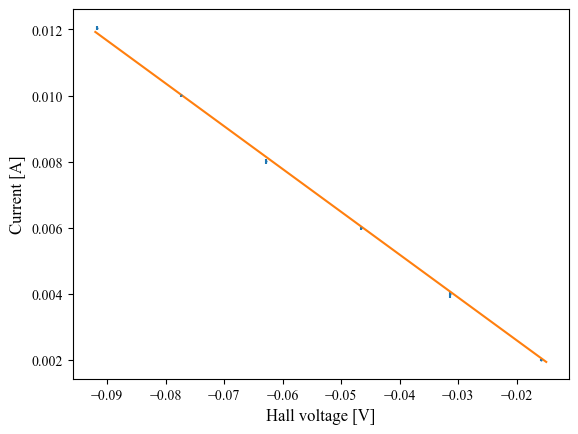

In [4]:
### Data processing for n-type semiconductor

num_data = len(n_I_1_B_1[:, 1])
num_bf = 1
n_bf = np.zeros((num_bf,num_data))
n_bf[0,:] = n_avg_Vh

n_A = np.zeros((num_bf,num_bf))
n_b = np.zeros(num_bf)                    
for k in range(num_bf):
    for j in range(num_bf):
        n_A[k,j] = np.sum(n_bf[k,:]*n_bf[j,:]/n_I_unc**2) 
    n_b[k] = np.sum(n_avg_I*n_bf[k,:]/n_I_unc**2)

n_A_inv = np.linalg.inv(n_A)

n_slope = np.linalg.solve(n_A,n_b)[0]                              
del_n_slope = np.sqrt(np.diag(n_A_inv))[0]
print(f"The slope is ({n_slope:.4f} ± {del_n_slope:.4f}) A/V.")

ax = plt.axes()
ax.errorbar(n_avg_Vh, n_avg_I, n_I_unc, fmt=".", markersize=1)
ax.plot(n_Vh_model, n_slope * n_Vh_model)
#ax.set_title('Determining Hall coefficient of n-type semiconductor')
ax.set_xlabel('Hall voltage [V]', fontsize=12)
ax.set_ylabel('Current [A]', fontsize=12)

The slope is (0.1363 ± 0.0004) A/V.


Text(0, 0.5, 'Current [A]')

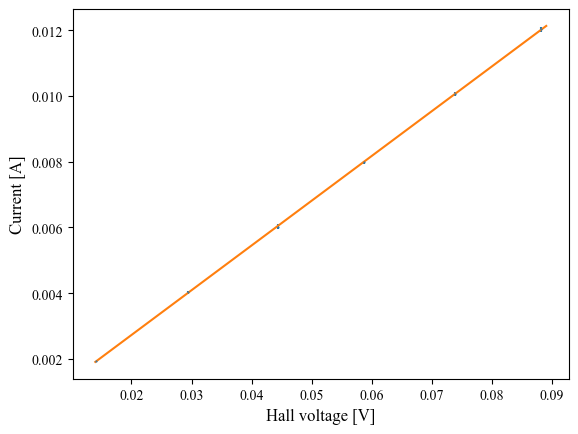

In [5]:
# Data processing for p-type semiconductor
                                                                                      
p_bf = np.zeros((num_bf,num_data))
p_bf[0,:] = p_avg_Vh

p_A = np.zeros((num_bf,num_bf))
p_b = np.zeros(num_bf)      
for k in range(num_bf):
    for j in range(num_bf):
        p_A[k,j] = np.sum(p_bf[k,:]*p_bf[j,:]/p_I_unc**2) 
    p_b[k] = np.sum(p_avg_I*p_bf[k,:]/p_I_unc**2)

p_A_inv = np.linalg.inv(p_A)

p_slope = np.linalg.solve(p_A,p_b)[0]                               
del_p_slope = np.sqrt(np.diag(p_A_inv))[0]
print(f"The slope is ({p_slope:.4f} ± {del_p_slope:.4f}) A/V.")

ax = plt.axes()
ax.errorbar(p_avg_Vh, p_avg_I, p_I_unc, fmt=".", markersize=1)
ax.plot(p_Vh_model, p_slope * p_Vh_model)
#ax.set_title('Determining Hall coefficient of p-type semiconductor')
ax.set_xlabel('Hall voltage [V]', fontsize=12)
ax.set_ylabel('Current [A]', fontsize=12)

Since $V_H = (\frac{R_HB}{H})I$, then $I = (\frac{H}{R_HB})V_H$. We graphed current against voltage, which means the slope of the graph is $\frac{H}{R_HB}$, therefore, $R_H = \frac{H}{(slope)\space \times \space B}$. Formulas for the other functions are given in later paragraphs below.

In [6]:
### Functions

def get_del_Rh(slope, del_slope, H, del_H, B, del_B):
    """Gets uncertainty of Hall coefficient"""
    dRh_dslope = -H / (B * slope**2)
    dRh_dH = 1 / (B * slope)
    dRh_dB = -H / (B**2 * slope)
    return np.sqrt((dRh_dslope * del_slope)**2 + (dRh_dH * del_H)**2 + (dRh_dB * del_B)**2)

# Calculating n (charge carrier density) and v_d/I (drift velocity per unit current) and their uncertainties

def get_n(Rh, charge_sign):
    """Gets charge carrier density"""
    return 1 / (Rh * charge_sign * e)

def get_vd(Rh, L, H):
    """Gets drift velocity per unit current"""
    return abs(Rh / (L * H))

def get_del_n(Rh, del_Rh):
    """Gets uncertainty of charge carrier density"""
    dn_dRh = -1 / (Rh**2 * e)
    return abs(dn_dRh * del_Rh)

def get_del_vd(Rh, del_Rh, L, del_L, H, del_H):
    """Gets uncertainty of drift velocity per unit current"""
    dv_dRh = 1 / (L * H)
    dv_dL = -Rh / (L**2 * H)
    dv_dH = -Rh / (L * H**2)
    return np.sqrt((dv_dRh * del_Rh)**2 + (dv_dL * del_L)**2 + (dv_dH * del_H)**2)

In [7]:
# Final values for concluding statement

n_Rh = H / (n_slope * B) 
del_n_Rh = get_del_Rh(n_slope, del_n_slope, H, del_H, B, del_B)
n_charge_carrier_density = get_n(n_Rh, -1)
del_n_charge_carrier_density = get_del_n(n_Rh, del_n_Rh)
n_drift_velocity_per_unit_current = get_vd(n_Rh, L, H)
del_n_drift_velocity_per_unit_current = get_del_vd(n_Rh, del_n_Rh, L, del_L, H, del_H)
print('(Without units or rounding)\n')
print(f'Hall coefficient for the n-type semiconductor is')
print(f'{n_Rh} ± {del_n_Rh}\n')
print(f'Charge charrier density n-type semiconductor is')
print(f'{n_charge_carrier_density} ± {del_n_charge_carrier_density}\n')
print(f'Drift velocity for the n-type semiconductor is')
print(f'{n_drift_velocity_per_unit_current} ± {del_n_drift_velocity_per_unit_current}\n')

p_Rh = H / (p_slope * B) 
del_p_Rh = get_del_Rh(p_slope, del_p_slope, H, del_H, B, del_B)
p_charge_carrier_density = get_n(p_Rh, 1)
del_p_charge_carrier_density = get_del_n(p_Rh, del_p_Rh)
p_drift_velocity_per_unit_current = get_vd(p_Rh, L, H)
del_p_drift_velocity_per_unit_current = get_del_vd(p_Rh, del_p_Rh, L, del_L, H, del_H)
print(f'Hall coefficient for the p-type semiconductor is')
print(f'{p_Rh} ± {del_p_Rh}\n')
print(f'Charge charrier density p-type semiconductor is')
print(f'{p_charge_carrier_density} ± {del_p_charge_carrier_density}\n')
print(f'Drift velocity for the p-type semiconductor is')
print(f'{p_drift_velocity_per_unit_current} ± {del_p_drift_velocity_per_unit_current}')

(Without units or rounding)

Hall coefficient for the n-type semiconductor is
-0.015852237292093233 ± 0.0017637555985599545

Charge charrier density n-type semiconductor is
3.937738969215839e+20 ± 4.38121700088748e+19

Drift velocity for the n-type semiconductor is
7575.740641382668 ± 1194.0046868044722

Hall coefficient for the p-type semiconductor is
0.015073601607368791 ± 0.0016770848721008463

Charge charrier density p-type semiconductor is
4.14114517288402e+20 ± 4.607427012812995e+19

Drift velocity for the p-type semiconductor is
7203.632787273019 ± 1135.3443418670684


The Hall coefficient is defined as $R_H = \frac{1}{nq}$, where $n$ is the number of charge carriers per unit volume (charge carrier density), and $q$ is the charge of the charge carrier ($±e$). Therefore, for n-type semiconductors, $R_H$ is negative, and $R_H$ is positive for p-type semiconductors. In the experiment, the n-type and p-type semiconductors were labelled, but our values for $R_H$ of the two semiconductors confirms this. Additionally,  drift velocity can be defined as $v_d = \frac{I}{nqA}$ where A is the cross-sectional area. We can have a drift velocity indepedent of current, call it a drift velocity per unit current, by dividing both sides by current. This gives $\frac{v_d}{I} = \frac{1}{nqA}$, which, for this experiment can be simplified to $\frac{v_d}{I} = \frac{R_H}{LH}$. Below are the final values the experiment aimed to find.

For the n-type semiconductor,

$R_H = (-0.0159 ± 0.0018) \space m^3C^{-1}$,

$n = (3.9 ± 0.4) \times 10^{20} \space m^{-3}$,

$\frac{v_d}{I} = (7.6 ± 1.2)\times 10^{3} \space ms^{-1}A^{-1}$.

For the p-type semiconductor,

$R_H = (0.0151 ± 0.0017) \space m^3C^{-1}$,

$n = (4.1 ± 0.5) \times 10^{20} \space m^{-3}$,

$\frac{v_d}{I} = (7.2 ± 1.1)\times 10^{3} \space ms^{-1}A^{-1}$.